In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.model.prophet import ProphetPredictor
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

Importing plotly failed. Interactive plots will not work.


In [2]:
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]

test_set_df = corrected_df.loc[(corrected_df.index >= config.train_start_time) &
                         (corrected_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

11:52:49 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing


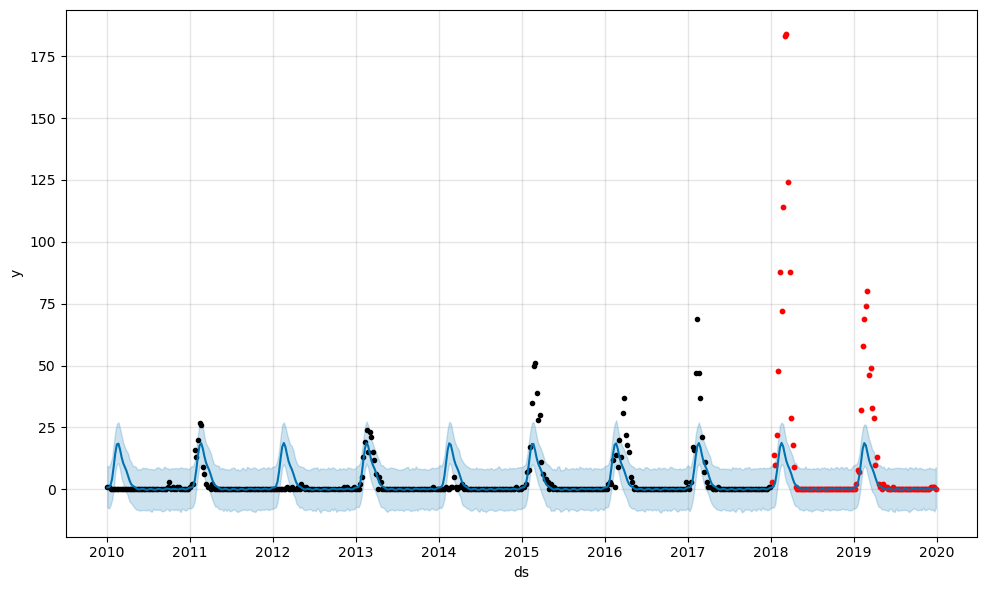

In [34]:
from prophet import Prophet
predictor = Prophet(growth= "flat")
prophet_df = corrected_df[corrected_df.location == "LK Bad Dürkheim"].reset_index(drop=False).rename(columns={"value":"y", "index":"ds"})[["ds", "y"]]
#prophet_df['y'] = np.log(prophet_df['y'] + 1)
train_prophet_df = prophet_df.loc[(prophet_df.ds >= config.train_start_time) &
                         (prophet_df.ds <= config.train_end_time),:]
test_prophet_df = prophet_df.loc[(prophet_df.ds >= config.train_end_time) &
                         (prophet_df.ds <= config.test_end_time),:]
predictor.fit(train_prophet_df)
future = predictor.make_future_dataframe(periods=104, freq=config.freq)
fcst = predictor.predict(future)
#for col in fcst.columns:
 #   if 'yhat' in col:
  #      fcst[col] = np.exp(fcst[col])-1
#test_prophet_df['y'] = np.exp(test_prophet_df['y'])-1
fig = predictor.plot(fcst)
plt.scatter((test_prophet_df['ds']),test_prophet_df['y'], c="red", s=10)

In [3]:
predictor = ProphetPredictor(prediction_length=104)
test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df[test_set_df.location == "LK Bad Dürkheim"],
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

forecasts = list(predictor.predict(train_set))

10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:54 - cmdstanpy - INFO - Chain [1]

2018-01-07 00:00:00


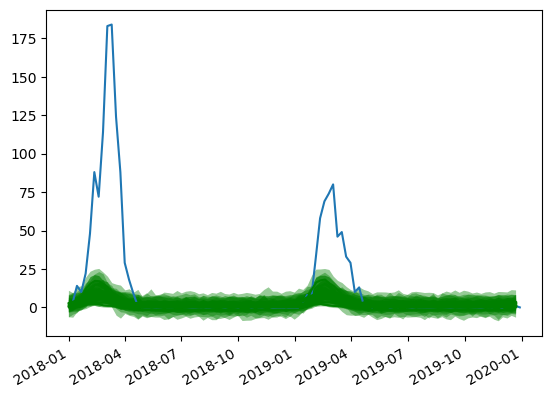

In [5]:
print(start_time)
prediction_intervals = (50.0, 90.0)
for location in ['LK Bad Dürkheim']:
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                        (corrected_df.index <= config.test_end_time) &
                        (corrected_df.index >= config.train_end_time)].index),
         corrected_df.loc[(corrected_df['location'] == location) &
                       (corrected_df.index <= config.test_end_time) &
                       (corrected_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #print(forecasts[-1:])
    for forecast in forecasts[-10:]:
        forecast.plot(prediction_intervals=prediction_intervals, color="g")
    plt.show()